In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [133]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [134]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [135]:
df['Date']=df.index

In [136]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [137]:
df=df.loc[mask]

In [138]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [139]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [140]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [141]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [142]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [143]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

LSTM+CNN

In [144]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(1)(x)
model_lstm_cnn=Model(i,x)
model_lstm_cnn.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_31 (Dense)            (None, 1)                 51  

In [145]:
check_point_lstm_cnn=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [146]:
model_lstm_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [147]:
r=model_lstm_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_cnn]
)

Epoch 1/100
4/4 [==============================] - 1s 83ms/step - loss: 4542.6250 - mae: 46.7859 - mse: 4542.6250 - val_loss: 1817.5914 - val_mae: 31.6855 - val_mse: 1817.5914
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 4393.0171 - mae: 45.7751 - mse: 4393.0171 - val_loss: 1797.2957 - val_mae: 31.8916 - val_mse: 1797.2957
Epoch 3/100
4/4 [==============================] - 0s 25ms/step - loss: 4403.1611 - mae: 46.1732 - mse: 4403.1611 - val_loss: 1792.9292 - val_mae: 31.8772 - val_mse: 1792.9292
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 4343.3896 - mae: 45.7392 - mse: 4343.3896 - val_loss: 1789.8921 - val_mae: 31.7419 - val_mse: 1789.8921
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 4293.6279 - mae: 45.5242 - mse: 4293.6279 - val_loss: 1801.7335 - val_mae: 31.6065 - val_mse: 1801.7335
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 4269.2163 - mae: 45.4036 - mse: 4269.2163 - val_

LSTM+GRU

In [148]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=GRU(200,return_sequences=True)(x)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm_gru=Model(i,x)
model_lstm_gru.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_17 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dense_32 (Dense)            (None, 50, 100)           20100     
                                                                 
 dense_33 (Dense)            (None, 50, 50)            5050      
                                                                 
 gru_8 (GRU)                 (None, 50, 200)           151200    
                                                                 
 gru_9 (GRU)                 (None, 50, 200)           2412

In [149]:
check_point_lstm_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [150]:
model_lstm_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [151]:
r=model_lstm_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_gru]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 4416.6968 - mae: 45.9159 - mse: 4416.6968 - val_loss: 1892.4604 - val_mae: 32.2528 - val_mse: 1892.4604
Epoch 2/100
4/4 [==============================] - 2s 631ms/step - loss: 4397.1499 - mae: 45.7299 - mse: 4397.1499 - val_loss: 1861.5754 - val_mae: 31.9862 - val_mse: 1861.5754
Epoch 3/100
4/4 [==============================] - 2s 600ms/step - loss: 4392.4004 - mae: 45.7558 - mse: 4392.4004 - val_loss: 1861.8391 - val_mae: 31.9892 - val_mse: 1861.8391
Epoch 4/100
4/4 [==============================] - 2s 602ms/step - loss: 4390.5479 - mae: 45.7339 - mse: 4390.5479 - val_loss: 1864.8502 - val_mae: 32.0163 - val_mse: 1864.8502
Epoch 5/100
4/4 [==============================] - 2s 596ms/step - loss: 4388.3994 - mae: 45.7298 - mse: 4388.3994 - val_loss: 1876.7061 - val_mae: 32.1198 - val_mse: 1876.7061
Epoch 6/100
4/4 [==============================] - 2s 597ms/step - loss: 4386.1021 - mae: 45.6959 - mse: 4386.1021 - 

Predictions



In [152]:
train_idx[:T+1]=False

In [153]:
Ptrain_lstm_cnn=model_lstm_cnn.predict(Xtrain).flatten()
Ptest_lstm_cnn=model_lstm_cnn.predict(Xtest).flatten()

In [154]:
Ptrain_lstm_gru=model_lstm_gru.predict(Xtrain).flatten()
Ptest_lstm_gru=model_lstm_gru.predict(Xtest).flatten()

In [ ]:
df.loc[train_idx,'Diff LSTM+CNN train prediction']=Ptrain_lstm_cnn
df.loc[test_idx,'Diff LSTM+CNN test prediction']=Ptest_lstm_cnn

In [155]:
df.loc[train_idx,'Diff LSTM+GRU train prediction']=Ptrain_lstm_gru
df.loc[test_idx,'Diff LSTM+GRU test prediction']=Ptest_lstm_gru

In [156]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [157]:
last_train=train.iloc[-1]['Prev Close']

In [158]:
df.loc[train_idx,'train_LSTM_CNN']=prev[train_idx]+Ptrain_lstm_cnn
df.loc[test_idx,'Prediction_LSTM_CNN']=prev[test_idx]+Ptest_lstm_cnn

In [159]:
df.loc[train_idx,'train_LSTM_GRU']=prev[train_idx]+Ptrain_lstm_gru
df.loc[test_idx,'Prediction_LSTM_GRU']=prev[test_idx]+Ptest_lstm_gru

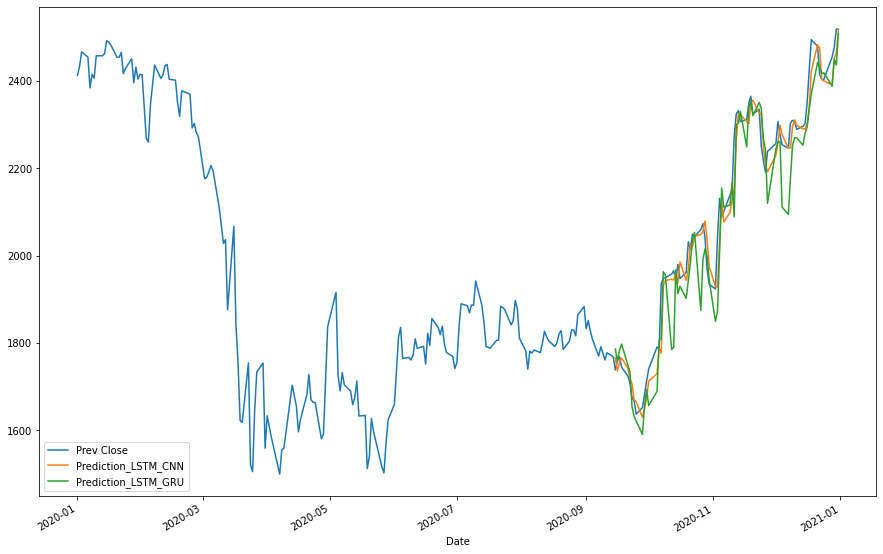

In [160]:
df[['Prev Close' ,'Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

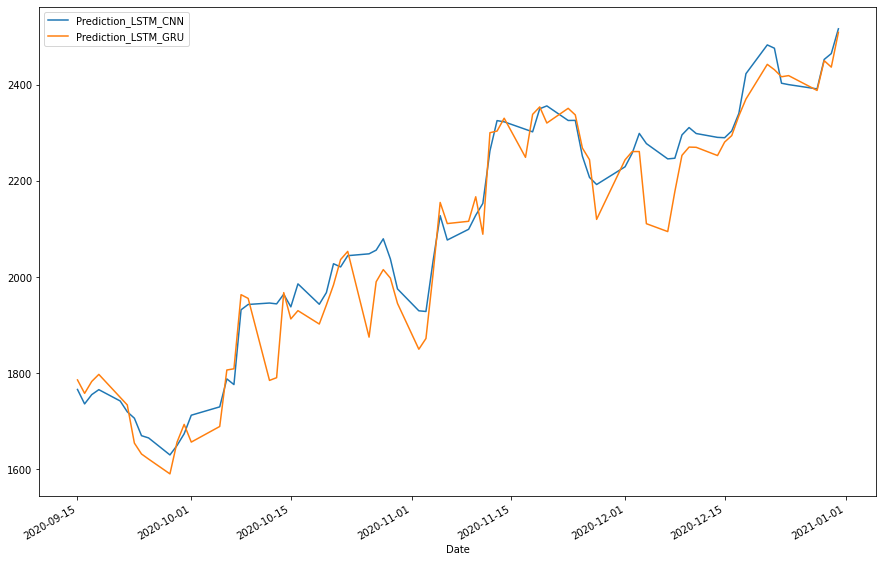

In [161]:
df[['Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

In [162]:
pred_lstm_cnn=df['Prediction_LSTM_CNN']
pred_lstm_cnn.dropna(inplace=True)

In [163]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

44.17500089644138


In [164]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_cnn)
print(error)

32.584693697055194


In [165]:
r2_score(test['Prev Close'],pred_lstm_cnn)

0.969427487689726

In [166]:
pred_lstm_gru=df['Prediction_LSTM_GRU']
pred_lstm_gru.dropna(inplace=True)

In [167]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

44.17500089644138


In [168]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_gru)
print(error)

54.12153563372294


In [169]:
r2_score(test['Prev Close'],pred_lstm_gru)

0.9163255071834419